In [1]:
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import sounddevice as sd
y, sr = librosa.load("00a80b4c8a.flac", sr=16000)

ImportError: No module named librosa

In [2]:
#pre-emphasis
alpha = 0.97
yemp = np.append(y[0], y[1:] - alpha * y[:-1])

In [3]:
# print(y)
# print(yemp)

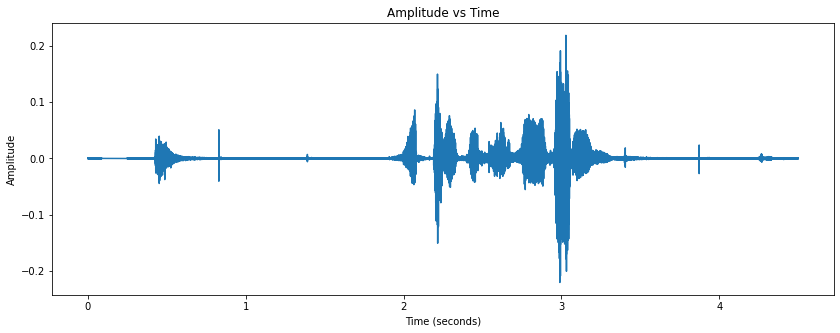

In [4]:
# plt.subplot(211)
fig, ax = plt.subplots(figsize=(14, 5))
time = np.linspace(0, len(y)/sr, num=len(y))
ax.set_title("Amplitude vs Time")
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time (seconds)")
ax.plot(time, yemp)
# plt.subplot(212)
# plt.plot(yemp)
fig.savefig("yemp.png")

In [5]:
#Framing
frame_size = 0.02
frame_stride = 0.01 # frame overlap = 0.02 - 0.01 = 0.01 (10ms)

frame_length, frame_step = int(round(frame_size * sr)), int(round(frame_stride * sr))  # Convert from seconds to samples
signal_length = len(yemp)

num_frames = int(np.ceil(float(signal_length - frame_length) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(yemp, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

In [6]:
#Window
frames = frames * np.hamming(frame_length)

In [11]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas



In [12]:
#Power Spectrum and FFT
NFFT = 512
magnitude = np.absolute(np.fft.rfft(frames, NFFT))
pow_frames = magnitude**2/NFFT

In [16]:

fig = plt.Figure()
canvas = FigureCanvas(fig)
ax = fig.add_subplot(111)
librosa.display.specshow(pow_frames,ax=ax, x_axis='time', y_axis='hz')
fig.savefig("spec.png")

In [27]:
#Filter Banks
nfilt = 40

low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sr / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
temp_bin = np.floor((NFFT + 1) * hz_points / sr)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))

for m in range(1, nfilt + 1):
    f_m_minus = int(temp_bin[m - 1])   # left
    f_m = int(temp_bin[m])             # center
    f_m_plus = int(temp_bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - temp_bin[m - 1]) / (temp_bin[m] - temp_bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (temp_bin[m + 1] - k) / (temp_bin[m + 1] - temp_bin[m])

filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

<AxesSubplot:xlabel='Time'>

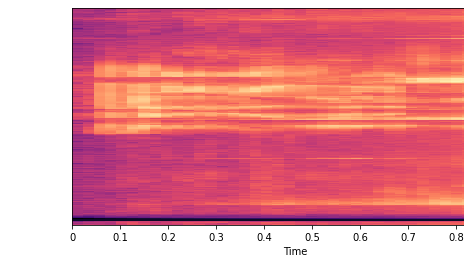

In [29]:
plt.figure(figsize=(8, 4))
librosa.display.specshow(filter_banks, x_axis='time')

In [33]:
# Discrete Cosine Transfrom is discarded (as we will be using deep learning approach)
mfcc =filter_banks - (np.mean(filter_banks, axis=0) + 1e-8) # For Normalization purpose


<AxesSubplot:xlabel='Time'>

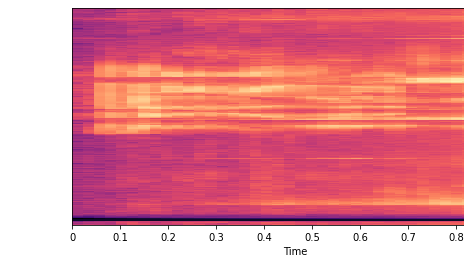

In [34]:
plt.figure(figsize=(8, 4))
librosa.display.specshow(filter_banks, x_axis='time')